In [182]:
!echo $WASHU_ROOT

/mnt/stripe/washu


In [183]:
DIR_PATH = '/mnt/stripe/bio/experiments/blueprint/data_redo'

In [561]:
LIFT_OVER_CHAIN_FILE = DIR_PATH + "/hg38ToHg19.over.chain.gz"

In [ ]:
%%bash -s $LIFT_OVER_CHAIN_FILE
# conda install -c bioconda ucsc-liftover
if [ ! -f $1 ]; then
  wget --timestamping 'ftp://hgdownload.cse.ucsc.edu/goldenPath/hg38/liftOver/hg38ToHg19.over.chain.gz' -O $1
fi

# Blueprint DMR processing

## Add OD / YD suffix

In [187]:
%%bash -s $DIR_PATH
cd $1/bw

# YD
find . -name "C005PS51.*" | xargs -I fname bash -c 'echo fname | sed s/\\.\\//YD1./g | xargs -I nname mv fname nname'
find . -name "S000RD54.*" | xargs -I fname bash -c 'echo fname | sed s/\\.\\//YD2./g | xargs -I nname mv fname nname'

# OD
find . -name "C000S5A1bs.*" | xargs -I fname bash -c 'echo fname | sed s/\\.\\//OD1./g | xargs -I nname mv fname nname'
find . -name "C0010KA2bs.*" | xargs -I fname bash -c 'echo fname | sed s/\\.\\//OD2./g | xargs -I nname mv fname nname'
find . -name "C001UYA3bs.*" | xargs -I fname bash -c 'echo fname | sed s/\\.\\//OD3./g | xargs -I nname mv fname nname'
find . -name "C004SQ51.*" | xargs -I fname bash -c 'echo fname | sed s/\\.\\//OD4./g | xargs -I nname mv fname nname'

## Convert to RRBS like output format
In order to reuse our scripts made for RRBS data let's convert *.bw data to similar *.txt files containing columns:

`chr  chrBase   base strand  coverage  freqC  freqT`

In [186]:
%%bash -s $DIR_PATH
DIR_PATH=$1

cd $DIR_PATH/bw
# ensusre bigWigToWig, wig2bed tools available
$WASHU_ROOT/downstream/preprocess_blueprint.sh

mkdir -p $DIR_PATH/mincov0
find . -name "*.mincov0.txt" | xargs -I fname mv fname $DIR_PATH/mincov0

mkdir -p $DIR_PATH/mincov10
find . -name "*.mincov10.txt" | xargs -I fname mv fname $DIR_PATH/mincov10

In [188]:
!ls -alh $DIR_PATH/mincov0

total 6.4G
drwxrwxr-x 2 user user 4.0K Aug 13 19:06 .
drwxrwxr-x 5 user user   60 Aug 13 18:36 ..
-rw-rw-r-- 1 user user 1.1G Aug 13 17:14 methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.txt
-rw-rw-r-- 1 user user 1.1G Aug 13 17:11 methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.txt
-rw-rw-r-- 1 user user 1.1G Aug 13 17:18 methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.txt
-rw-rw-r-- 1 user user 1.1G Aug 13 17:21 methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.txt
-rw-rw-r-- 1 user user 1.1G Aug 13 17:25 methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.txt
-rw-rw-r-- 1 user user 1.1G Aug 13 17:29 methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.txt


## Collect cytosine coverage

In [350]:
%%writefile $DIR_PATH/collect_cytosine_data.py
import pandas as pd
from pathlib import Path

def collect_cytosine_data(input_dir, result_path, tag_filter):
    files = [f for f in Path(input_dir).glob("*.*") if (tag_filter is None) or (tag_filter in f.name)]

    cols = []
    for file in Path(input_dir).glob("*.*"):
        if (tag_filter is None) or (tag_filter in file.name):
            df = pd.read_csv(str(file), sep = "\t", index_col="chrBase", usecols=["chrBase", "coverage"])
            col = df["coverage"]
            col.name = file.stem
            cols.append(col)
            
    def sorter(v):
        chr, offset = v.split('.')
        return chr, int(offset)

    df = pd.DataFrame.from_dict({c.name: c for c in cols}, dtype=str)
    df.ix[sorted(df.index, key=sorter)].to_csv(result_path, sep="\t", index_label="chrBase", na_rep="NA")

if __name__ == "__main__":
    import argparse
    
    parser = argparse.ArgumentParser()

    parser.add_argument('input_dir', help = 'Directory with methylation *.txt files')
    parser.add_argument('output', help = 'Result methylation table *.tsv file')
    parser.add_argument('--tag', help = 'Filter methylation files with names including this tag string')
    args = parser.parse_args()

    collect_cytosine_data(args.input_dir, args.output, args.tag)

Overwriting /mnt/stripe/bio/experiments/blueprint/data_redo/collect_cytosine_data.py


In [370]:
!python $DIR_PATH/collect_cytosine_data.py -h

usage: collect_cytosine_data.py [-h] [--tag TAG] input_dir output

positional arguments:
  input_dir   Directory with methylation *.txt files
  output      Result methylation table *.tsv file

optional arguments:
  -h, --help  show this help message and exit
  --tag TAG   Filter methylation files with names including this tag string


In [351]:
!python $DIR_PATH/collect_cytosine_data.py $DIR_PATH/mincov0 $DIR_PATH/coverage.df.hg38.tsv

In [352]:
!head $DIR_PATH/coverage.df.hg38.tsv

chrBase	methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0	methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0	methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0	methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0	methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0	methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0
chr1.10469	8	2	NA	NA	NA	5
chr1.10471	8	NA	6	9	3	5
chr1.10484	8	NA	8	10	NA	5
chr1.10489	8	5	10	9	3	6
chr1.10493	8	5	11	7	NA	7
chr1.10497	9	6	13	6	NA	7
chr1.10525	10	6	10	4	NA	7
chr1.10531	7	5	12	4	NA	NA
chr1.10542	7	5	9	5	NA	NA


## Filter cytosine coverage

In [353]:
%%writefile $DIR_PATH/filter_by_mean_cov.py
import pandas as pd

def filter_by_mean_coverage(coverage_table_path, result_path, min_mean_coverage):
    coverage_df = pd.read_csv(coverage_table_path, sep='\t')
    print("All cytosines number:", coverage_df.shape[0])

    # Consider cytosines covered with >= 1 reads in all samples
    df = coverage_df.dropna()
    # Filter by mean coverage threshold
    df = df[df.mean(axis=1).values >= min_mean_coverage]
    # convert float values to int:
    data_cols = list(df.columns)[1:]
    df.loc[:, data_cols] = df.loc[:, data_cols].astype(int)
    print("Covered cytosines + mean coverage >= {} number: {}".format(min_mean_coverage, df.shape[0]))
    
    df.to_csv(result_path, sep='\t', index=False)

if __name__ == "__main__":
    import argparse
    
    parser = argparse.ArgumentParser(description="Filter cytosine positions covered in all donors with at least on read and with mean coverage across all donors at least given threshold")
    parser.add_argument('input', help = 'Coverage table by donor *.tsv path')
    parser.add_argument('coverage', help = 'Cytosine mean coverage threshold')
    parser.add_argument('output', help = 'Filtered table output path')
    args = parser.parse_args()

    filter_by_mean_coverage(args.input, args.output, int(args.coverage))

Overwriting /mnt/stripe/bio/experiments/blueprint/data_redo/filter_by_mean_cov.py


In [371]:
!python $DIR_PATH/filter_by_mean_cov.py -h

usage: filter_by_mean_cov.py [-h] input coverage output

Filter cytosine positions covered in all donors with at least on read and with
mean coverage across all donors at least given threshold

positional arguments:
  input       Coverage table by donor *.tsv path
  coverage    Cytosine mean coverage threshold
  output      Filtered table output path

optional arguments:
  -h, --help  show this help message and exit


In [354]:
!python $DIR_PATH/filter_by_mean_cov.py $DIR_PATH/coverage.df.hg38.tsv 10 $DIR_PATH/coverage.df.hg38.filtered.mean10.tsv

All cytosines number: 28274081
Covered cytosines + mean coverage >= 10 number: 23242924


In [365]:
COVERAGE_TSV = DIR_PATH + "/coverage.df.hg38.filtered.mean10.tsv"
COVERAGE_FILTER_BED = COVERAGE_TSV.replace(".tsv", ".offsets.txt")

In [538]:
%%bash -s $COVERAGE_TSV $COVERAGE_FILTER_BED

# Split extract first column ("chrN:offset") and split it in chr number and offset
awk -F'[.\t]' -v OFS='\t' '{ if(NR!=1) print $1,$2,$2+1 }' $1 > $2
echo "Done: $2"

Done: /mnt/stripe/bio/experiments/blueprint/data_redo/coverage.df.hg38.filtered.mean10.offsets.txt


In [367]:
!wc -l $COVERAGE_FILTER_BED

23242924 /mnt/stripe/bio/experiments/blueprint/data_redo/coverage.df.hg38.filtered.mean10.offsets.txt


## Call BackGround

In [ ]:
# 50 because methpipe with window 1:50:1 ?
# python3 scripts/python/assemble_covered_regions.py -l 50 -o assembly.test -e
#
# todo maybe ran methpipe merge instead of assemble_covered_regions?

In [ ]:
%%bash -s $LIFT_OVER_CHAIN_FILE $DIR_PATH/coverage.df.hg38.filtered.mean10.offsets.txt $DIR_PATH/coverage.df.hg19.filtered.mean10.offsets.txt

LIFT_OVER_CHAIN_FILE=$1
FILE=$2
OUTPUT=$3

which liftOver &>/dev/null || {
    echo "liftOver not found!"
    echo "Download: <http://hgdownload.cse.ucsc.edu/admin/exe/> or"
    echo "  conda install -c bioconda ucsc-liftover"
    exit 1
}

liftOver $FILE $LIFT_OVER_CHAIN_FILE $OUTPUT $OUTPUT.unmapped

In [ ]:
%%writefile $DIR_PATH/assemble_covered_regions.py
from pipeline_utils import *


def expand_region(start, end, min_length, chr_length):
    delta = (min_length - (end - start + 1)) / 2
    start = round(max(0, start - delta))
    end = round(min(chr_length, end + delta))
    return start, end


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('-c', '--sorted_cytosines', required=True,
                        help='set of cytosines (has to be sorted)')
    parser.add_argument('-l', '--readLength', required=True,
                        help='size of the read to use when merging')
    parser.add_argument('-o', '--outputFile', help='output file name', required=True)
    parser.add_argument('-e', '--expand', help='whether to expand regions to the read length',
                        action='store_true')
    parser.add_argument('-i', '--path_to_indexes', action=WritableDirectory, type=str,
                        help='Path to indexes')
    parser.add_argument('-g', '--genome', type=str, help='Genome')
    args = parser.parse_args()

    all_cytosines = args.sorted_cytosines
    read_length = int(args.readLength)
    output_file = args.outputFile
    to_expand = args.expand
    genome = args.genome
    indexes = os.path.join(args.path_to_indexes, genome)

    chrom_sizes_file = os.path.join(indexes, genome + ".chrom.sizes")

    # read chromosome sizes to not exceed length
    chrom_sizes = {}
    with open(chrom_sizes_file) as inp:
        for line in inp:
            chr, length = line.strip().split()
            chrom_sizes[chr] = int(length)

    # compile covered regions: merge cytosines that are closer than read_length
    results = []
    with open(all_cytosines) as inp:
        is_initialized = False
        for line in inp:
            chr, start = line.strip().split()[0:2]
            start = int(start)
            end = start + 1
            if not is_initialized:
                cur_chr, cur_start, cur_end = chr, start, end
                is_initialized = True
                continue
            if chr == cur_chr and start - read_length <= cur_end:
                cur_end = end
            else:
                # expand small regions: region can't be smaller than read_length if flag is set
                if to_expand and cur_end - cur_start + 1 < read_length:
                    cur_start, cur_end = expand_region(cur_start, cur_end, read_length,
                                                       chrom_sizes[cur_chr])
                results.append((cur_chr, cur_start, cur_end))
                cur_chr, cur_start, cur_end = chr, start, end

    # write results to file
    with open(output_file, 'w') as out:
        for (chr, start, end) in results:
            out.write('\t'.join([chr, str(start), str(end)]) + '\n')


if __name__ == "__main__":
    main()



In [ ]:
!python $DIR_PATH/assemble_covered_regions.py -h

In [ ]:
#!python $WASHU_ROOT/downstream/methylation/assemble_covered_regions.py -l 50 -e -o 
!python $DIR_PATH/assemble_covered_regions.py -l 50 -e -g hg19 -i /mnt/stripe/bio/genomes -c $DIR_PATH/coverage.df.hg19.filtered.mean10.offsets.txt -o $DIR_PATH/bp.all.covered.regions.hg19.filtered.mean10.bed

In [ ]:
!sort -k1,1 -k2,3n $DIR_PATH/bp.all.covered.regions.hg19.filtered.mean10.bed > $DIR_PATH/bp.all.covered.regions.hg19.filtered.mean10.sorted.bed

In [ ]:
!wc -l $DIR_PATH/bp.all.covered.regions.hg19.filtered.mean10.bed
!wc -l $DIR_PATH/bp.all.covered.regions.hg19.filtered.mean10.sorted.bed

# MethPipe

## DMRs Pipeline

### Sort  files

In [372]:
%%writefile $DIR_PATH/sort_data.sh
#!/bin/bash

>&2 echo "sort_data $@"
if [ $# -lt 2 ]; then
    echo "Need at least 2 parameters! <METHYLOME_FILES_DIR> <OUTPUT_DIR>"
    exit 1
fi
    
METHYLOME_FILES_DIR=$1
OUTPUT_DIR=$2

cd $WORKING_DIR
mkdir -p $OUTPUT_DIR

for F in $(find $METHYLOME_FILES_DIR -maxdepth 1 -mindepth 1 -type f);
do
    NAME=${F##*/}
    NAME=${NAME%%.txt}
    OUT_NAME=$OUTPUT_DIR/${NAME}.sorted.txt
    head -1 $F > $OUT_NAME
    tail -n+2 $F | sed -e 's/ \+/\t/g' | sort -k2,2 -k3,3n  >> $OUT_NAME
    echo "Done: ${OUT_NAME}"
done

Overwriting /mnt/stripe/bio/experiments/blueprint/data_redo/sort_data.sh


In [359]:
!chmod u+x $DIR_PATH/sort_data.sh

In [347]:
!bash $DIR_PATH/sort_data.sh $DIR_PATH/mincov0 $DIR_PATH/sorted_data

/mnt/stripe/bio/experiments/blueprint/data_redo/sorted_data/methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.sorted.txt
/mnt/stripe/bio/experiments/blueprint/data_redo/sorted_data/methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.sorted.txt
/mnt/stripe/bio/experiments/blueprint/data_redo/sorted_data/methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.sorted.txt
/mnt/stripe/bio/experiments/blueprint/data_redo/sorted_data/methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.sorted.txt
/mnt/stripe/bio/experiments/blueprint/data_redo/sorted_data/methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.sorted.txt
/mnt/stripe/bio/experiments/blueprint/data_redo/sorted_data/methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.sorted.txt


### Convert cytosine coverage files to *.meth format

In [380]:
%%writefile $DIR_PATH/prepare_methfiles.py
import argparse
import os
from pathlib import Path
from itertools import islice

# run example:
# bash run_python3.sh scripts/python/prepare_methfiles.py '/methylation/sorted_data 
# /methylation/cytosines.bed /methylation/clean_methpipe/data
# -p methylcall* -s minavcov10.sorted.meth' methfiles

def convert_line_to_methpipe_format(line):
    id, chr, pos, strand, coverage, freqC, freqT = line.strip().split('\t')
    strand = '+' if strand == 'F' else '-'
    return '\t'.join([chr, pos, strand, 'CpG', str(float(freqC) / 100.0), coverage])


def prepare_methfiles(chr_base_set, data_path, file_pattern, suffix, output_path):
    for f in data_path.glob(file_pattern):
        result_path = output_path / f.with_suffix(suffix).name
        with open(str(result_path), 'w') as out:
            with open(str(f)) as inp:
                # skip header (1st line)
                for line in islice(inp, 1, None):
                    chr_base = line.split()[0]
                    
                    # take only desired cytosines
                    if chr_base in chr_base_set:
                        out.write(convert_line_to_methpipe_format(line) + '\n')


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('input_directory', help='Directory with initial sorted files')
    parser.add_argument('cytosine', help="File with filtered cytosines offsets in format 'chrName\toffset'")
    parser.add_argument('output_directory', help='Output directory')
    parser.add_argument('-s', '--suffix', help="Suffix to add", default=".meth")
    parser.add_argument('-p', '--pattern',
                        help="Optional pattern for filtering methylation files from input dir", 
                        default="*")

    args = parser.parse_args()

    # read in cytosines to keep
    chr_base_set = set()
    with open(args.cytosine) as f:
        for line in f:
            # take only first 2 columns from file
            chr, offset = line.strip().split()[0:2]
            chr_base_set.add("{}.{}".format(chr, offset))

    prepare_methfiles(
        chr_base_set,
        Path(args.input_directory), args.pattern, 
        args.suffix, Path(args.output_directory)
    )


if __name__ == "__main__":
    main()

Overwriting /mnt/stripe/bio/experiments/blueprint/data_redo/prepare_methfiles.py


In [369]:
!python $DIR_PATH/prepare_methfiles.py -h

usage: prepare_methfiles.py [-h] [-s SUFFIX] [-p PATTERN]
                            input_directory cytosine output_directory

positional arguments:
  input_directory       Directory with initial sorted files
  cytosine              File with filtered cytosines offsets in format
                        'chrName offset'
  output_directory      Output directory

optional arguments:
  -h, --help            show this help message and exit
  -s SUFFIX, --suffix SUFFIX
                        Suffix to add
  -p PATTERN, --pattern PATTERN
                        Optional pattern for filtering methylation files from
                        input dir


In [418]:
METHPIPE_WORKDIR_PATH = DIR_PATH + "/methpipe"

In [381]:
!mkdir -p $METHPIPE_WORKDIR_PATH
!python $DIR_PATH/prepare_methfiles.py $DIR_PATH/sorted_data $DIR_PATH/coverage.df.hg38.filtered.mean10.offsets.txt $METHPIPE_WORKDIR_PATH

In [421]:
!ls -lah $METHPIPE_WORKDIR_PATH

total 9.8G
drwxrwxr-x 2 user user 4.0K Aug 14 03:10 .
drwxrwxr-x 7 user user 4.0K Aug 14 10:25 ..
-rw-rw-r-- 1 user user  412 Aug 14 02:56 design_matrix.txt
-rw-rw-r-- 1 user user 1.2M Aug 14 03:10 hg38ToHg19.over.chain.gz
-rw-rw-r-- 1 user user 721M Aug 14 01:58 methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.sorted.meth
-rw-rw-r-- 1 user user 718M Aug 14 01:59 methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.sorted.meth
-rw-rw-r-- 1 user user 725M Aug 14 02:01 methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.sorted.meth
-rw-rw-r-- 1 user user 739M Aug 14 02:03 methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.sorted.meth
-rw-rw-r-- 1 user user 745M Aug 14 01:55 methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.sorted.meth
-rw-rw-r-- 1 user user 725M Aug 14 01:56 methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.sorted.meth
-rw-rw-r-- 1 user user 1.3G Aug 14 03:28 proportion_table.hg19.txt
-rw-rw-r-- 1 user user 1.5G Aug 14 03:27 proportion_table.hg19.txt.bed4
-r

### Generate proportion and experiment design tables for methpipe

In [422]:
%%writefile $DIR_PATH/build_design_matrix.py
import argparse
import os
import subprocess

def build_design_matrix(table_path, output_path):
    # construct design table using proportion table header
    with open(table_path) as f:
        prop_header = f.readline().strip().split()
        
    with open(output_path, 'w') as out:
        out.write('\t'.join(['base', 'case', 'batch']) + '\n')
        base = '1'

        for methfile in prop_header:
            case, batch = '0', '0'
            
            donor_id = methfile.split('.')[2]
            if donor_id.startswith('OD'):
                case = '1'
            if int(donor_id[2:]) > 10:
                batch = '1'
            out.write('\t'.join([methfile, base, case, batch]) + '\n')


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Build MethPipe design matrix using proportions table")
    parser.add_argument('table', help='MethPipe proportion tabls file')
    parser.add_argument('output', help='Design matrix file name')
    args = parser.parse_args()

    build_design_matrix(args.table, args.output)

Overwriting /mnt/stripe/bio/experiments/blueprint/data_redo/build_design_matrix.py


In [402]:
%%bash -s $METHPIPE_WORKDIR_PATH
METHPIPE_INPUT_PATH=$1
merge-methcounts -t $(find $METHPIPE_WORKDIR_PATH -name "*.meth" -printf '%p ') > $METHPIPE_WORKDIR_PATH/proportion_table.txt

In [423]:
!python $DIR_PATH/build_design_matrix.py $METHPIPE_WORKDIR_PATH/proportion_table.txt $METHPIPE_WORKDIR_PATH/design_matrix.txt
!cat $METHPIPE_WORKDIR_PATH/design_matrix.txt

base	case	batch
methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.sorted	1	0	0
methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.sorted	1	0	0
methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.sorted	1	1	0
methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.sorted	1	1	0
methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.sorted	1	1	0
methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.sorted	1	1	0


### Liftover DMRs proportion table

In [565]:
%%writefile $DIR_PATH/liftover_proportion_table_hg38_to_hg19.sh
#!/usr/bin/env bash
# author: roman.chernyatchik@jetbrains.com

>&2 echo "liftover_proportion_table_hg38_to_hg19 $@"
if [ $# -lt 3 ]; then
    echo "Need at least 3 parameters! <WORKING_DIR> <PROPORTION_TABLE_PATH> <LIFTOVER_HG38_TO_HG19_CHAIN_FILE>"
    exit 1
fi

WORKING_DIR=$1
PROPORTION_TABLE=$2
LIFT_OVER_CHAIN_FILE=$3

which liftOver &>/dev/null || {
    echo "liftOver not found!"
    echo "Download: <http://hgdownload.cse.ucsc.edu/admin/exe/> or"
    echo "  conda install -c bioconda ucsc-liftover"
    exit 1
}

PROPORTION_TABLE_NAME=${PROPORTION_TABLE##*/}   
PROPORTION_TABLE_BED4=$WORKING_DIR/$PROPORTION_TABLE_NAME.bed4
NEW_PREFIX="${WORKING_DIR}/${PROPORTION_TABLE_NAME%%.txt}.hg19"

cd $WORKING_DIR
cat $PROPORTION_TABLE | sed s/'\t'/';'/g | awk -F: '{ if (NR != 1) print $1,$2-1,$2,$3":"$4 }' > $PROPORTION_TABLE_BED4
                     
liftOver $PROPORTION_TABLE_BED4 $LIFT_OVER_CHAIN_FILE $NEW_PREFIX.txt.bed4 $NEW_PREFIX.unmapped.bed4
echo "Total cytosines: $(wc -l $PROPORTION_TABLE_BED4)"
echo "Converted hg38 -> hg19 cytosines: $(wc -l  $NEW_PREFIX.txt.bed4)"
echo "Unmapped hg38 -> hg19 cytosines: $(wc -l $NEW_PREFIX.unmapped.bed4)"

# convert bed4 to proportion table
head -n 1 $PROPORTION_TABLE > $NEW_PREFIX.txt
awk -v OFS=':' '{ print $1,$3,$4 }' $NEW_PREFIX.txt.bed4 | sed s/';'/'\t'/g >> $NEW_PREFIX.txt

Overwriting /mnt/stripe/bio/experiments/blueprint/data_redo/liftover_proportion_table_hg38_to_hg19.sh


In [566]:
!chmod u+x $DIR_PATH/liftover_proportion_table_hg38_to_hg19.sh

In [435]:
#!bash chmod u+x $DIR_PATH/liftover_proportion_table_hg38_to_hg19.sh
!bash $DIR_PATH/liftover_proportion_table_hg38_to_hg19.sh $METHPIPE_WORKDIR_PATH $METHPIPE_WORKDIR_PATH/proportion_table.txt $LIFT_OVER_CHAIN_FILE

liftover_proportion_table_hg38_to_hg19 /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/proportion_table.txt
^C


### Call DMRs

In [456]:
%%writefile $DIR_PATH/run_methpipe.sh
#!/bin/bash

>&2 echo "run_methpipe $@"
if [ $# -lt 4 ]; then
    echo "Need at least 4 parameters! <DESIGN> <TABLE> <OUTPUT> <NAME>"
    echo "   DESIGN: MethPipe design matrix path"
    echo "   TABLE:  MethPipe proportion table path"
    echo "   OUTPUT: Design matrix path"
    echo "   DESIGN: Design matrix path"
    exit 1
fi
    
DESIGN=$1
TABLE=$2
OUTPUT=$3
NAME=$4

#rm ${NAME}.log

WDIR=`pwd`
ADJ_OUTPUT="${OUTPUT%.*}".narrow.adjusted.bed
REG_OUTPUT="${ADJ_OUTPUT%.*}".regions.bed

cd $WDIR
DMC_N=$(cat $TABLE | wc -l)
echo "Processing  cytosines: $DMC_N"
echo "Track progress using cmd:" 
echo "    date && LINES=\$(wc -l $OUTPUT); echo $(python -c 'import sys; print("lines:", sys.argv[1], "completed: ", str(int(100.0*int(sys.argv[1])/23242925*1000)/1000.0) + " %")' $LINES)"    

echo "[$(date)] 1. radmeth regression ..."    
radmeth regression -factor case -o $OUTPUT $DESIGN $TABLE
echo "$(date)  Done: $OUTPUT"

echo "[$(date)] 2. radmeth adjust ..."    
radmeth adjust -bins 1:50:1 $OUTPUT > $ADJ_OUTPUT
echo "$(date)  Done: $ADJ_OUTPUT"

echo "[$(date)] 3. radmeth adjust ..."    
radmeth merge -p 0.05 $ADJ_OUTPUT > $REG_OUTPUT
echo "$(date)  Done: $REG_OUTPUT"

Overwriting /mnt/stripe/bio/experiments/blueprint/data_redo/run_methpipe.sh


In [457]:
!chmod u+x $DIR_PATH/run_methpipe.sh

In [458]:
METHPIPE_OUTPUT_PATH = METHPIPE_WORKDIR_PATH + "/output"

In [ ]:
!mkdir -p $METHPIPE_OUTPUT_PATH
!bash $DIR_PATH/run_methpipe.sh $METHPIPE_WORKDIR_PATH/design_matrix.txt $METHPIPE_WORKDIR_PATH/proportion_table.hg19.txt $METHPIPE_OUTPUT_PATH/dmc.hg19.bed
!ls -alh $METHPIPE_OUTPUT_PATH

Split DMRs in UP and DOWN:

#### Optional liftover
Liftover hg38 -> hg19 if hg38 proportion table used

In [567]:
%%writefile $DIR_PATH/liftover_methpipe_dmrs.sh
#!/usr/bin/env bash
# author: roman.chernyatchik@jetbrains.com

>&2 echo "liftover_methpipe_dmrs $@"
if [ $# -lt 3 ]; then
    echo "Need at least 3 parameters! <WORKING_DIR> <DMRS_PATH> <LIFTOVER_HG38_TO_HG19_CHAIN_FILE>"
    exit 1
fi

WORKING_DIR=$1
DMRS_PATH=$2
LIFT_OVER_CHAIN_FILE=$3

which liftOver &>/dev/null || {
    echo "liftOver not found!"
    echo "Download: <http://hgdownload.cse.ucsc.edu/admin/exe/> or"
    echo "  conda install -c bioconda ucsc-liftover"
    exit 1
}

DMRS_NAME=${DMRS_PATH##*/}   
DMRS_BED4=$WORKING_DIR/$DMRS_NAME.bed4
NEW_PREFIX="${WORKING_DIR}/${DMRS_NAME%%.txt}.hg19"

cd $WORKING_DIR
awk '{print $1,$2,$3,$4NR":"$5":"$6}' $DMRS_PATH > $DMRS_BED4
                        
liftOver $DMRS_BED4 $LIFT_OVER_CHAIN_FILE $NEW_PREFIX.bed4 $NEW_PREFIX.unmapped.bed4
echo "Total regions: $(wc -l $DMRS_BED4)"
echo "Converted hg38 -> hg19 regions: $(wc -l  $NEW_PREFIX.bed4)"
echo "Unmapped hg38 -> hg19 regions: $(wc -l $NEW_PREFIX.unmapped.bed4)"

# convert bed4 to regions
awk -v FS=':' -v OFS='\t' '{ print $1,$2,$3 }' $NEW_PREFIX.bed4 > $NEW_PREFIX.bed

Overwriting /mnt/stripe/bio/experiments/blueprint/data_redo/liftover_methpipe_dmrs.sh


In [463]:
!bash $DIR_PATH/liftover_methpipe_dmrs.sh $METHPIPE_OUTPUT_PATH $METHPIPE_OUTPUT_PATH/dmc.hg38.narrow.adjusted.regions.bed $LIFT_OVER_CHAIN_FILE

liftover_methpipe_dmrs /mnt/stripe/bio/experiments/blueprint/data/methpipe_output_4 /mnt/stripe/bio/experiments/blueprint/data/methpipe_output_4/hg38.dmc.narrow.adjusted.regions.bed
Reading liftover chains
Mapping coordinates
Total regions: 63126 /mnt/stripe/bio/experiments/blueprint/data/methpipe_output_4/hg38.dmc.narrow.adjusted.regions.bed.bed4
Converted hg38 -> hg19 regions: 62920 /mnt/stripe/bio/experiments/blueprint/data/methpipe_output_4/hg38.dmc.narrow.adjusted.regions.bed.hg19.bed4
Unmapped hg38 -> hg19 regions: 412 /mnt/stripe/bio/experiments/blueprint/data/methpipe_output_4/hg38.dmc.narrow.adjusted.regions.bed.hg19.unmapped.bed4


#### Filter & Split in UP/DOWN

In [472]:
!ls -lah $METHPIPE_OUTPUT_PATH

total 2.7M
drwxrwxr-x 2 user user   57 Aug 14 12:06 .
drwxrwxr-x 3 user user 4.0K Aug 14 12:06 ..
-rw-rw-r-- 1 user user 2.7M Aug 14 12:06 dmc.hg19.narrow.adjusted.regions.bed


In [514]:
%%writefile $DIR_PATH/filter_dmrs.sh

WORKING_DIR=$1
DMRS=$2
PREFIX=$3
CYTOSINES_MIN_COUNT=$4
METHYLATION_CHANGE=$5

OUTPUT_PREFIX="$WORKING_DIR/$PREFIX.ncyto.ge$CYTOSINES_MIN_COUNT.mch.ge${METHYLATION_CHANGE}"
cat $DMRS | awk -v MCH=$METHYLATION_CHANGE -v N_C=$CYTOSINES_MIN_COUNT 'function abs(v) {return v < 0 ? -v : v} {if (abs($6) >= MCH && $5 >= N_C) print}' | sort -k1,1 -k2,3n > $OUTPUT_PREFIX.bed
echo "Done: $OUTPUT_PREFIX.bed"
echo "  Filtered $(cat $OUTPUT_PREFIX.bed | wc -l)/$(cat $DMRS | wc -l) regions where each region has >= $CYTOSINES_MIN_COUNT and abs(methylatio change) >= $METHYLATION_CHANGE"
awk '{ if ($6 > 0) print }' $OUTPUT_PREFIX.bed > $OUTPUT_PREFIX.up.bed
echo "  UP: $(cat $OUTPUT_PREFIX.up.bed | wc -l)"
awk '{ if ($6 < 0) print }' $OUTPUT_PREFIX.bed > $OUTPUT_PREFIX.down.bed
echo "  DOWN: $(cat $OUTPUT_PREFIX.down.bed | wc -l)"

Overwriting /mnt/stripe/bio/experiments/blueprint/data_redo/filter_dmrs.sh


In [512]:
!chmod u+x $DIR_PATH/filter_dmrs.sh

In [516]:
!bash $DIR_PATH/filter_dmrs.sh $METHPIPE_OUTPUT_PATH $METHPIPE_OUTPUT_PATH/dmc.hg19.narrow.adjusted.regions.bed bp.dmrs 3 0.025
!bash $DIR_PATH/filter_dmrs.sh $METHPIPE_OUTPUT_PATH $METHPIPE_OUTPUT_PATH/dmc.hg19.narrow.adjusted.regions.bed bp.dmrs 3 0.3
!bash $DIR_PATH/filter_dmrs.sh $METHPIPE_OUTPUT_PATH $METHPIPE_OUTPUT_PATH/dmc.hg19.narrow.adjusted.regions.bed bp.dmrs 3 0.5

Done: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/bp.dmrs.ncyto.ge3.mch.ge0.025.bed
  Filtered 24842/62920 regions where each region has >= 3 and abs(methylatio change) >= 0.025
  UP: 10736
  DOWN: 14106
Done: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/bp.dmrs.ncyto.ge3.mch.ge0.3.bed
  Filtered 5398/62920 regions where each region has >= 3 and abs(methylatio change) >= 0.3
  UP: 1175
  DOWN: 4223
Done: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/bp.dmrs.ncyto.ge3.mch.ge0.5.bed
  Filtered 851/62920 regions where each region has >= 3 and abs(methylatio change) >= 0.5
  UP: 79
  DOWN: 772


## Methylation@LOI

First liftover to hg19 (same genome as our LOI regions)

In [614]:
!mkdir -p $METHPIPE_WORKDIR_PATH/hg19

In [781]:
%%bash -s $METHPIPE_WORKDIR_PATH/hg19 $METHPIPE_WORKDIR_PATH $LIFT_OVER_CHAIN_FILE

WORKDIR_PATH=$1
METH_FILES_DIR=$2
LIFT_OVER_CHAIN_FILE=$3

for METH_FILE in $(find $METH_FILES_DIR -maxdepth 1 -name "*.sorted.meth"); do
    METH_FILE_NAME=${METH_FILE##*/}
    
    METH_FILE_HG19="$WORKDIR_PATH/${METH_FILE_NAME%%.sorted.meth}.hg19.sorted.meth"
    #if [ ! -f $METH_FILE_HG19 ]; then
        echo "Converting '$METH_FILE' to hg19"
        awk -v OFS='\t' '{ print $1,$2,$2+1,$3":"$4":"$5":"$6 }' $METH_FILE > $METH_FILE.bed4
        
        CONVERTED_PATH=$METH_FILE_HG19.bed4
        UNMAPPED_PATH=$METH_FILE_HG19.unmapped.bed4
        liftOver $METH_FILE.bed4 $LIFT_OVER_CHAIN_FILE $CONVERTED_PATH $UNMAPPED_PATH
        echo "  $(cat $METH_FILE | wc -l): total cytosines in ${METH_FILE##*/}"
        echo "  $(cat $CONVERTED_PATH | wc -l): converted hg38 -> hg19 cytosines in ${CONVERTED_PATH##*/}"
        echo "  $(cat $UNMAPPED_PATH | wc -l): unmapped hg38 -> hg19 cytosines in ${UNMAPPED_PATH##*/}"

        # convert bed4 to *.meth format
        awk -F '[\t:]' -v OFS='\t' '{ print $1,$3,$4,$5,$6,$7 }' $CONVERTED_PATH > $METH_FILE_HG19
        echo "  Done: $METH_FILE_HG19"
        echo
    else
        echo "Already exists: $METH_FILE_HG19"
    fi
done

Converting '/mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.sorted.meth' to hg19
Converting '/mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.sorted.meth' to hg19
Converting '/mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.sorted.meth' to hg19
Converting '/mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.sorted.meth' to hg19
Converting '/mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.sorted.meth' to hg19
Converting '/mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.sorted.meth' to hg19


**roimethstat**

The output format is also 6-column BED, and the score column now takes the average methylation level through the interval, weighted according to the number of reads informing about each CpG or C in the methylation file. The 4th, or ”name” column encodes several other pieces of information that can be used to filter the regions. The original name of the region in the input regions file is retained, but separated by a colon (:) are, in the following order, (1) the number of CpGs in the region, (2) the number of CpGs covered at least once, (3) the number of observations in reads indicating in the region that indicate methylation, and (4) the total number of observations from reads in the region. The methylation level is then (3) divided by (4).

Works rather fast

In [796]:
%%writefile $DIR_PATH/batch_roimethstat.sh

METH_FILES_DIR=$1
METH_FILE_SUFFIX_PATTERN=$2
OUTPUT_DIR=$3
LOI_SUFFIX=$4

METH_FILES="$(find $METH_FILES_DIR -maxdepth 1 -name $METH_FILE_SUFFIX_PATTERN)"

process_loi() {
  LOI_FILE=$1

  for METH_FILE in $METH_FILES; do
    METH_FILE_NAME=${METH_FILE##*/}

    LOI_NAME=${LOI_FILE##*/}
    LOI_NAME=${LOI_NAME%%$LOI_SUFFIX}

    echo "Processing:"
    echo "  Methylation file: $METH_FILE"
    echo "  LOI             : $LOI_FILE"

    roimethstat -o $OUTPUT_DIR/$LOI_NAME@$METH_FILE_NAME $LOI_FILE $METH_FILE
  done
}

mkdir -p $OUTPUT_DIR
if [[ ! -z "${@:5}" ]]; then
  for F in "${@:5}"; do
    process_loi "$F"
  done
else
  while read -r line; do
      process_loi "$line"
  done
fi

Overwriting /mnt/stripe/bio/experiments/blueprint/data_redo/batch_roimethstat.sh


### DMRS, all covered regions,  Histone modifications methylation signal:

In [775]:
%%bash -s $METHPIPE_WORKDIR_PATH/hg19 $DIR_PATH $METHPIPE_OUTPUT_PATH
METH_DIR=$1
DIR_PATH=$2
METHPIPE_OUTPUT_PATH=$3
OUTPUT_DIR=$METHPIPE_OUTPUT_PATH/loi

# histones
find /mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/weak_consensus -name "H*_span_weak_consensus.bed" | bash $DIR_PATH/batch_roimethstat.sh $METH_DIR "*.sorted.meth" $OUTPUT_DIR "_span_weak_consensus.bed"

# CGI
bash $DIR_PATH/batch_roimethstat.sh $METH_DIR "*.sorted.meth" $OUTPUT_DIR "_span_weak_consensus.bed" /mnt/stripe/bio/raw-data/aging/loci_of_interest/ucsc_cpgIslandExt.hg19.bed

# dmrs
find $METHPIPE_OUTPUT_PATH -name "bp.dmrs*.bed" | xargs -I fname bash -c 'cut -f 1-4 fname > fname.bed4'
find $METHPIPE_OUTPUT_PATH -name "bp.dmrs*.bed.bed4" | bash $DIR_PATH/batch_roimethstat.sh $METH_DIR "*.sorted.meth" $OUTPUT_DIR ".bed.bed4"

bash $DIR_PATH/batch_roimethstat.sh $METH_DIR "*.sorted.meth" $OUTPUT_DIR ".sorted.bed" $DIR_PATH/"bp.all.covered.regions.hg19.filtered.mean10.sorted.bed"

Process is terminated.


### Histone modifications signal in DMRs

In [805]:
%%writefile $DIR_PATH/intersect_file_with_loi.sh

DMR_FILE=$1
OUTPUT_DIR=$2

process_loi() {
  LOI_FILE=$1
  bedtools intersect -wa -a $LOI_FILE -b $DMR_FILE > "$OUTPUT_DIR/${LOI_FILE##*/}.${DMR_FILE##*/}"
}

mkdir -p $OUTPUT_DIR
if [[ ! -z "${@:3}" ]]; then
  for F in "${@:3}"; do
    process_loi "$F"
  done
else
  while read -r line; do
      process_loi "$line"
  done
fi

Overwriting /mnt/stripe/bio/experiments/blueprint/data_redo/intersect_file_with_loi.sh


In [808]:
%%writefile $DIR_PATH/calc_meth_loi.sh
DMRS_FILE=$1
METH_DIR=$2
OUTPUT_DIR=$3
DIR_PATH=$4

#Intersect: Histones & DMRs
find /mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/weak_consensus -name "H*_span_weak_consensus.bed" | bash $DIR_PATH/intersect_file_with_loi.sh $DMRS_FILE $OUTPUT_DIR

# histones
mkdir -p $OUTPUT_DIR/loi
find $OUTPUT_DIR -maxdepth 1 -name "H*.bed4" | bash $DIR_PATH/batch_roimethstat.sh $METH_DIR "*.sorted.meth" $OUTPUT_DIR/loi "_span_weak_consensus.bed*"

Overwriting /mnt/stripe/bio/experiments/blueprint/data_redo/calc_meth_loi.sh


In [814]:
!bash $DIR_PATH/calc_meth_loi.sh $METHPIPE_OUTPUT_PATH/bp.dmrs.ncyto.ge3.mch.ge0.025.down.bed.bed4 $METHPIPE_WORKDIR_PATH/hg19 $METHPIPE_OUTPUT_PATH/loi/hist@dmrs.0.025.down $DIR_PATH
#+ !bash $DIR_PATH/calc_meth_loi.sh $METHPIPE_OUTPUT_PATH/bp.dmrs.ncyto.ge3.mch.ge0.025.up.bed.bed4 $METHPIPE_WORKDIR_PATH/hg19 $METHPIPE_OUTPUT_PATH/loi/hist@dmrs.0.025.up $DIR_PATH
#!bash $DIR_PATH/calc_meth_loi.sh $METHPIPE_OUTPUT_PATH/bp.dmrs.ncyto.ge3.mch.ge0.025.bed.bed4 $METHPIPE_WORKDIR_PATH/hg19 $METHPIPE_OUTPUT_PATH/loi/hist@dmrs.0.025 $DIR_PATH

!bash $DIR_PATH/calc_meth_loi.sh $METHPIPE_OUTPUT_PATH/bp.dmrs.ncyto.ge3.mch.ge0.3.down.bed.bed4 $METHPIPE_WORKDIR_PATH/hg19 $METHPIPE_OUTPUT_PATH/loi/hist@dmrs.0.3.down $DIR_PATH
!bash $DIR_PATH/calc_meth_loi.sh $METHPIPE_OUTPUT_PATH/bp.dmrs.ncyto.ge3.mch.ge0.3.up.bed.bed4 $METHPIPE_WORKDIR_PATH/hg19 $METHPIPE_OUTPUT_PATH/loi/hist@dmrs.0.3.up $DIR_PATH
#!bash $DIR_PATH/calc_meth_loi.sh $METHPIPE_OUTPUT_PATH/bp.dmrs.ncyto.ge3.mch.ge0.3.bed.bed4 $METHPIPE_WORKDIR_PATH/hg19 $METHPIPE_OUTPUT_PATH/loi/hist@dmrs.0.3 $DIR_PATH

Processing:
  Methylation file: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/hg19/methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
  LOI             : /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/loi/hist@dmrs.0.025.down/H3K27ac_span_weak_consensus.bed.bp.dmrs.ncyto.ge3.mch.ge0.025.down.bed.bed4
Processing:
  Methylation file: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/hg19/methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
  LOI             : /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/loi/hist@dmrs.0.025.down/H3K27ac_span_weak_consensus.bed.bp.dmrs.ncyto.ge3.mch.ge0.025.down.bed.bed4
Processing:
  Methylation file: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/hg19/methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
  LOI             : /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/loi/hist@dmrs.0.025.down/H3K27ac_span_weak_consensus.be

Processing:
  Methylation file: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/hg19/methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
  LOI             : /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/loi/hist@dmrs.0.025.down/H3K4me3_span_weak_consensus.bed.bp.dmrs.ncyto.ge3.mch.ge0.025.down.bed.bed4
Processing:
  Methylation file: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/hg19/methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
  LOI             : /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/loi/hist@dmrs.0.025.down/H3K4me3_span_weak_consensus.bed.bp.dmrs.ncyto.ge3.mch.ge0.025.down.bed.bed4
Processing:
  Methylation file: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/hg19/methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
  LOI             : /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/loi/hist@dmrs.0.025.down/H3K4me3_span_weak_consensus.be

Processing:
  Methylation file: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/hg19/methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
  LOI             : /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/loi/hist@dmrs.0.3.down/H3K4me1_span_weak_consensus.bed.bp.dmrs.ncyto.ge3.mch.ge0.3.down.bed.bed4
Processing:
  Methylation file: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/hg19/methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
  LOI             : /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/loi/hist@dmrs.0.3.down/H3K4me1_span_weak_consensus.bed.bp.dmrs.ncyto.ge3.mch.ge0.3.down.bed.bed4
Processing:
  Methylation file: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/hg19/methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
  LOI             : /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/loi/hist@dmrs.0.3.down/H3K4me1_span_weak_consensus.bed.bp.dmrs.

Processing:
  Methylation file: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/hg19/methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
  LOI             : /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/loi/hist@dmrs.0.3.up/H3K36me3_span_weak_consensus.bed.bp.dmrs.ncyto.ge3.mch.ge0.3.up.bed.bed4
Processing:
  Methylation file: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/hg19/methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
  LOI             : /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/loi/hist@dmrs.0.3.up/H3K36me3_span_weak_consensus.bed.bp.dmrs.ncyto.ge3.mch.ge0.3.up.bed.bed4
Processing:
  Methylation file: /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/hg19/methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
  LOI             : /mnt/stripe/bio/experiments/blueprint/data_redo/methpipe/output/loi/hist@dmrs.0.3.up/H3K36me3_span_weak_consensus.bed.bp.dmrs.ncyto.g

### Visualization

In [822]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

def plot_loi_avg_meth_info(loi_dir, pattern, loi_remove_prefix=None, title="Methylation @ BP DMRs"):
    result_dfs = []
    files = list(loi_dir.glob(pattern))
    for i, file in enumerate(files, 1):
        print("{}/{}: {}".format(i, len(files), file.name))

        name = file.stem
        loi, donor = name.split('@')
        if loi_remove_prefix:
            loi = loi.replace(loi_remove_prefix, "")
              
        donor = donor.split(".")[2]

        #df = pd.read_csv(file, sep="\t", usecols=[0,1,2,4], names=["chr", "start", "end", "avg_meth"], nrows=4)
        df = pd.read_csv(file, sep="\t", usecols=[4], names=["avg_meth"])
        df["id"] = "{}@{}".format(donor,loi)
        df["donor"] = donor
        df["loi"] = loi
        df["age"] = donor[0:2]

        result_dfs.append(df)

    df = pd.concat(result_dfs, axis=0)

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 5)
    ax.set_title(title)
    plt.xticks(rotation=90)
    g = sns.boxplot(data=df, x = "id", y="avg_meth", hue="age", ax=ax)
    display(g)


    fig, ax = plt.subplots()
    fig.set_size_inches(20, 5)
    ax.set_title(title)
    plt.xticks(rotation=90)
    g = sns.boxplot(data=df, x = "loi", y="avg_meth", hue="age", ax=ax)
    display(g)

#### DMRs

1/54: bp.dmrs.ncyto.ge3.mch.ge0.025@methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
2/54: bp.dmrs.ncyto.ge3.mch.ge0.025@methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
3/54: bp.dmrs.ncyto.ge3.mch.ge0.025@methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
4/54: bp.dmrs.ncyto.ge3.mch.ge0.025@methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.hg19.sorted.meth
5/54: bp.dmrs.ncyto.ge3.mch.ge0.025@methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.hg19.sorted.meth
6/54: bp.dmrs.ncyto.ge3.mch.ge0.025@methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.hg19.sorted.meth
7/54: bp.dmrs.ncyto.ge3.mch.ge0.3@methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
8/54: bp.dmrs.ncyto.ge3.mch.ge0.3@methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
9/54: bp.dmrs.ncyto.ge3.mch.ge0.3@methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
10/54: bp.dmrs.ncyto.ge3.mch.ge0.3@methylcall.CpG.OD2

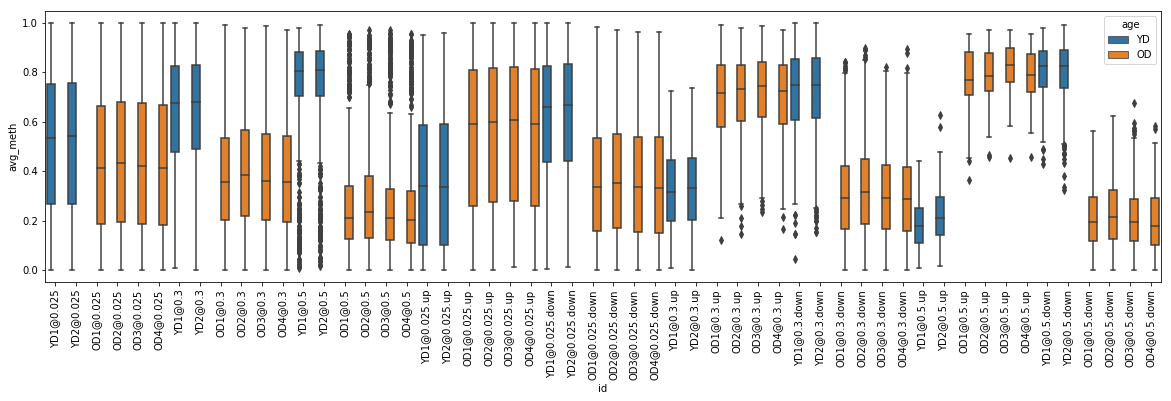

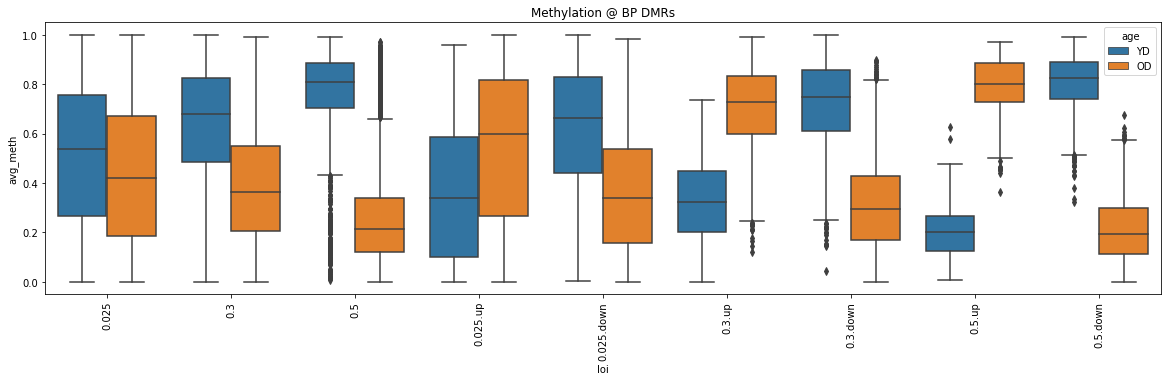

In [778]:
plot_loi_avg_meth_info(Path(METHPIPE_OUTPUT_PATH) / "loi", "bp.dmrs*.meth", loi_remove_prefix="bp.dmrs.ncyto.ge3.mch.ge")

#### Histones

1/30: H3K27ac@methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
2/30: H3K27ac@methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
3/30: H3K27ac@methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
4/30: H3K27ac@methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.hg19.sorted.meth
5/30: H3K27ac@methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.hg19.sorted.meth
6/30: H3K27ac@methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.hg19.sorted.meth
7/30: H3K27me3@methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
8/30: H3K27me3@methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
9/30: H3K27me3@methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
10/30: H3K27me3@methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.hg19.sorted.meth
11/30: H3K27me3@methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.hg19.sorted.meth
12/30: H3K27me3@methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.

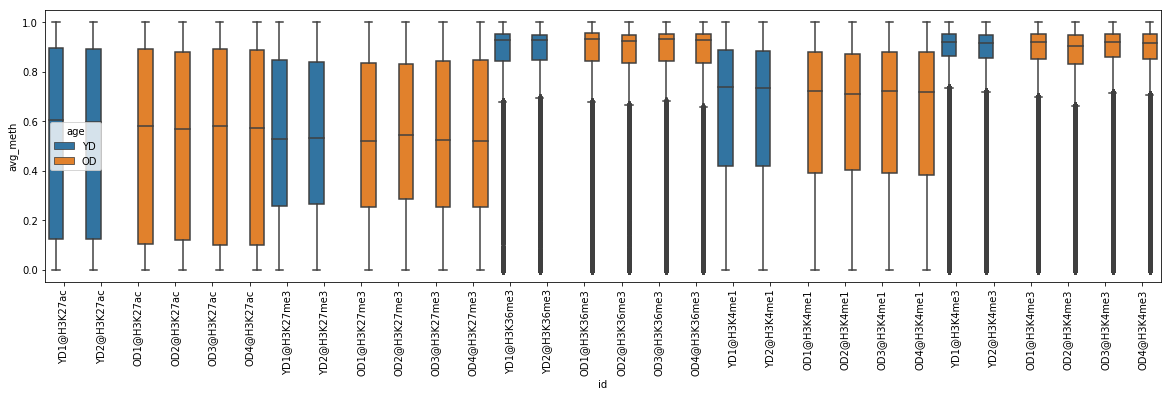

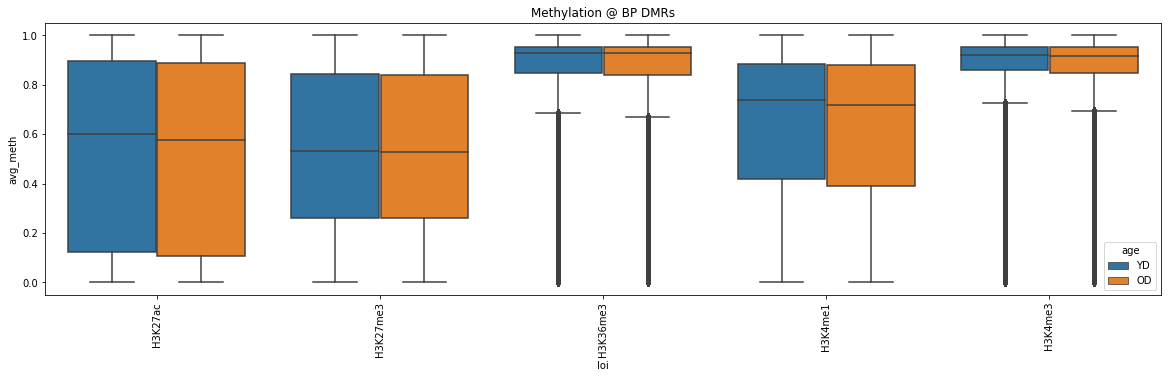

In [779]:
plot_loi_avg_meth_info(Path(METHPIPE_OUTPUT_PATH) / "loi", "H*.meth")

#### Histones at DMRs

1/30: H3K27ac@methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
2/30: H3K27ac@methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
3/30: H3K27ac@methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
4/30: H3K27ac@methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.hg19.sorted.meth
5/30: H3K27ac@methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.hg19.sorted.meth
6/30: H3K27ac@methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.hg19.sorted.meth
7/30: H3K27me3@methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
8/30: H3K27me3@methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
9/30: H3K27me3@methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
10/30: H3K27me3@methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.hg19.sorted.meth
11/30: H3K27me3@methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.hg19.sorted.meth
12/30: H3K27me3@methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.

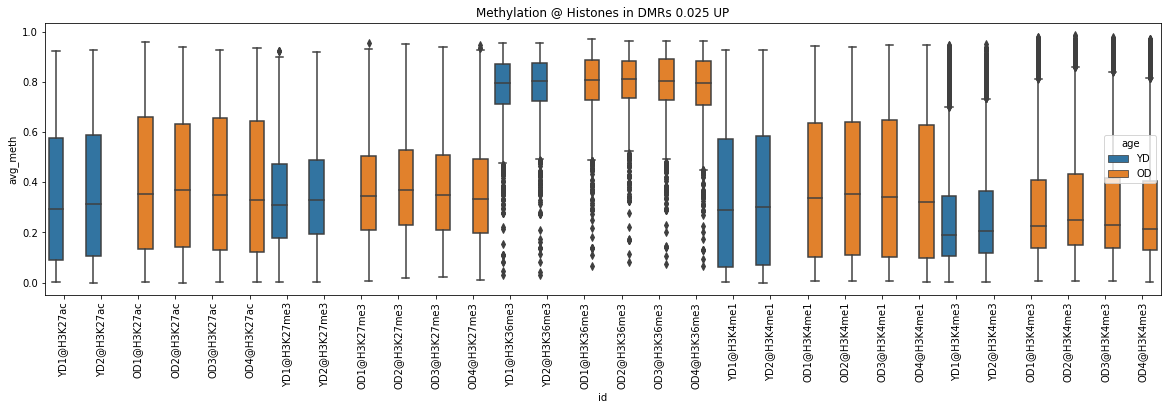

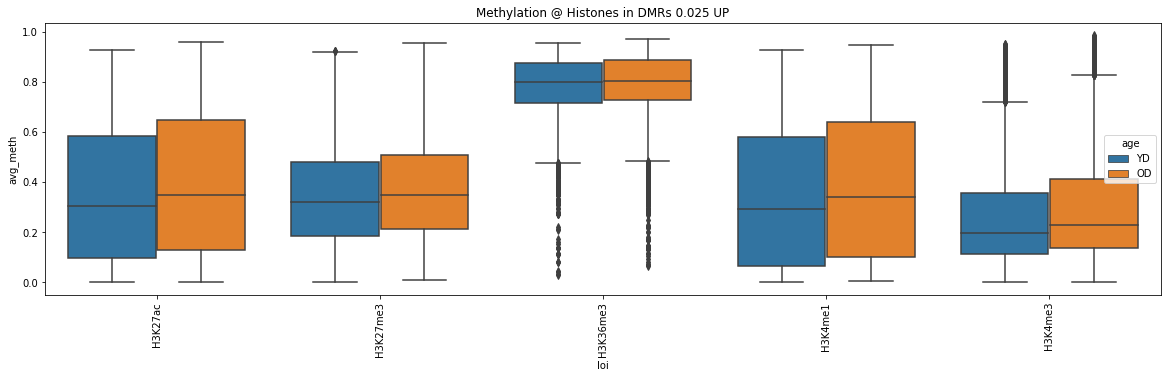

In [827]:
plot_loi_avg_meth_info(Path(METHPIPE_OUTPUT_PATH) / "loi" / "hist@dmrs.0.025.up" / "loi", "H*.meth", title="Methylation @ Histones in DMRs 0.025 UP")

1/30: H3K27ac@methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
2/30: H3K27ac@methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
3/30: H3K27ac@methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
4/30: H3K27ac@methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.hg19.sorted.meth
5/30: H3K27ac@methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.hg19.sorted.meth
6/30: H3K27ac@methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.hg19.sorted.meth
7/30: H3K27me3@methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
8/30: H3K27me3@methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
9/30: H3K27me3@methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
10/30: H3K27me3@methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.hg19.sorted.meth
11/30: H3K27me3@methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.hg19.sorted.meth
12/30: H3K27me3@methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.

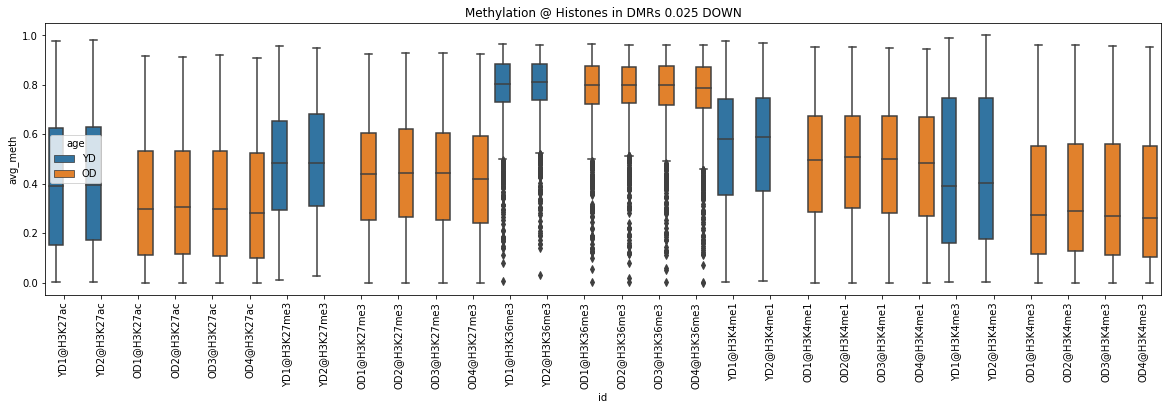

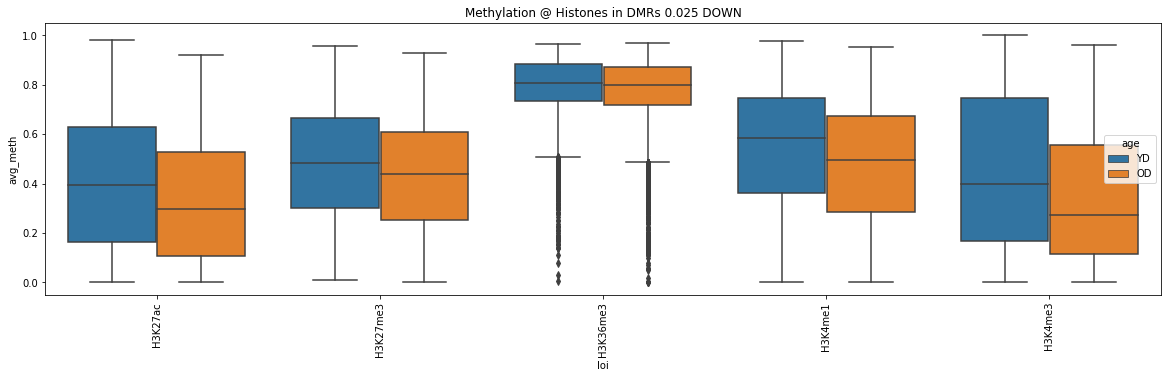

In [828]:
plot_loi_avg_meth_info(Path(METHPIPE_OUTPUT_PATH) / "loi" / "hist@dmrs.0.025.down" / "loi", "H*.meth", title = "Methylation @ Histones in DMRs 0.025 DOWN")

1/30: H3K27ac@methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
2/30: H3K27ac@methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
3/30: H3K27ac@methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
4/30: H3K27ac@methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.hg19.sorted.meth
5/30: H3K27ac@methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.hg19.sorted.meth
6/30: H3K27ac@methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.hg19.sorted.meth
7/30: H3K27me3@methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
8/30: H3K27me3@methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
9/30: H3K27me3@methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
10/30: H3K27me3@methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.hg19.sorted.meth
11/30: H3K27me3@methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.hg19.sorted.meth
12/30: H3K27me3@methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.

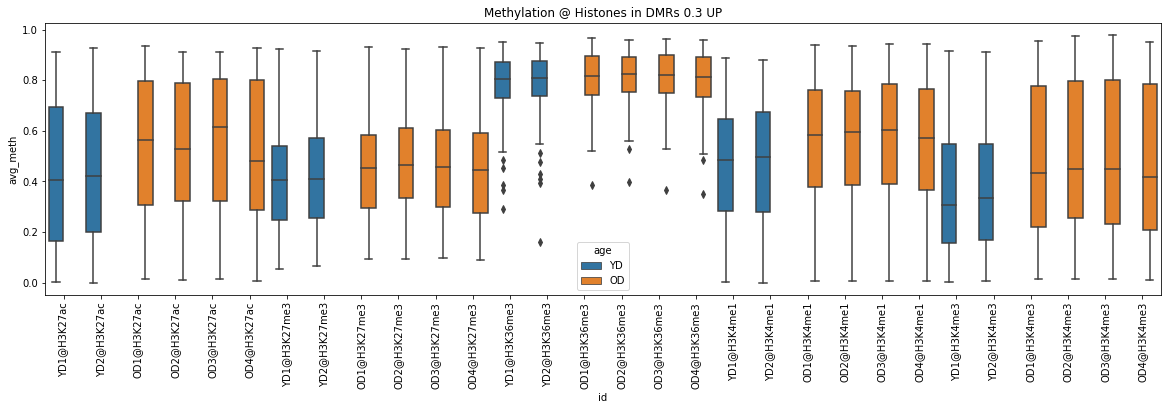

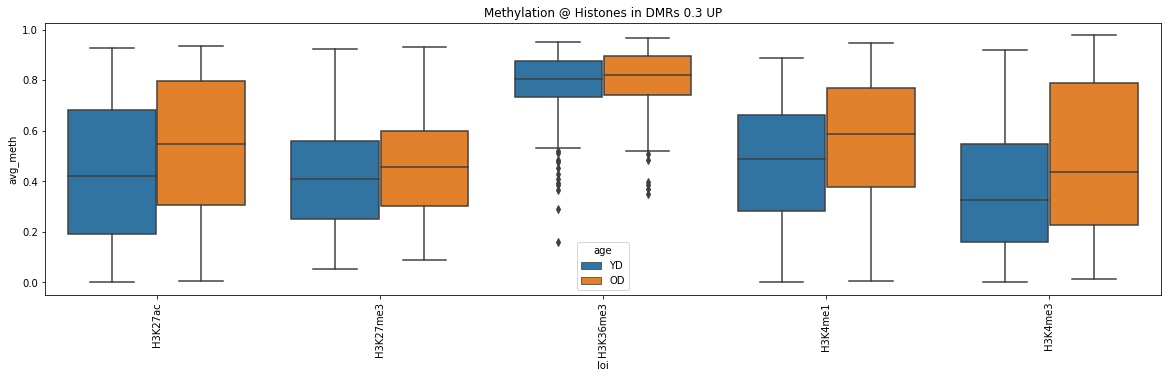

In [831]:
plot_loi_avg_meth_info(Path(METHPIPE_OUTPUT_PATH) / "loi" / "hist@dmrs.0.3.up" / "loi", "H*.meth", title= "Methylation @ Histones in DMRs 0.3 UP")

1/30: H3K27ac@methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
2/30: H3K27ac@methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
3/30: H3K27ac@methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
4/30: H3K27ac@methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.hg19.sorted.meth
5/30: H3K27ac@methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.hg19.sorted.meth
6/30: H3K27ac@methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.hg19.sorted.meth
7/30: H3K27me3@methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.hg19.sorted.meth
8/30: H3K27me3@methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.hg19.sorted.meth
9/30: H3K27me3@methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.hg19.sorted.meth
10/30: H3K27me3@methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.hg19.sorted.meth
11/30: H3K27me3@methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.hg19.sorted.meth
12/30: H3K27me3@methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.

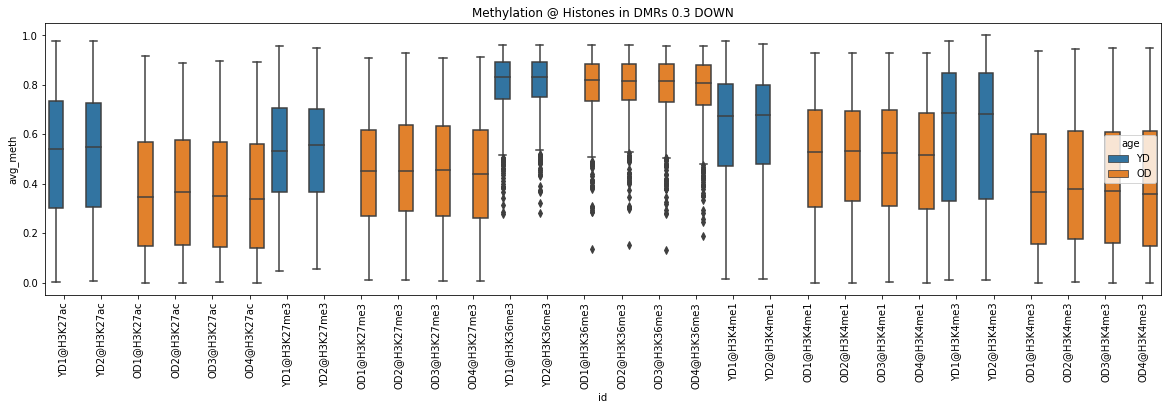

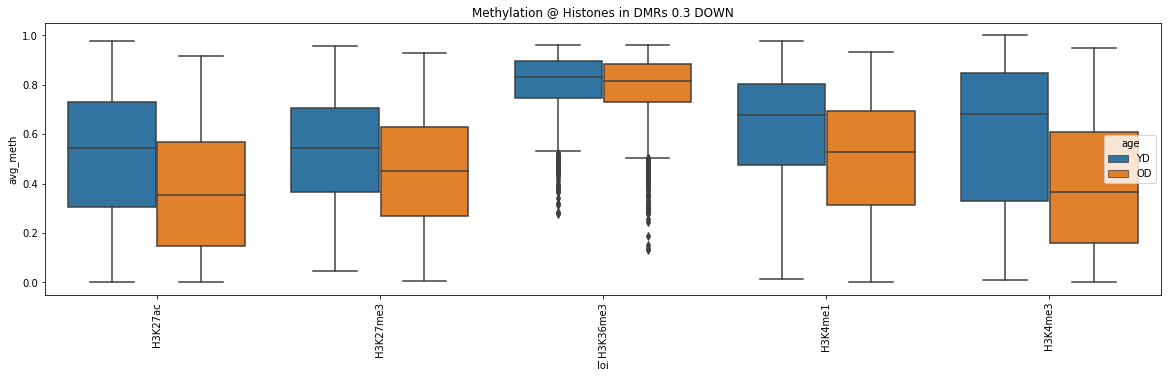

In [830]:
plot_loi_avg_meth_info(Path(METHPIPE_OUTPUT_PATH) / "loi" / "hist@dmrs.0.3.down" / "loi", "H*.meth", title= "Methylation @ Histones in DMRs 0.3 DOWN")

## TMP: Chr19 only

In [ ]:
### %%bash -s $DIR_PATH
DIR_PATH=$1
SUFFIX=4_1
INPUT_DIR=$DIR_PATH/methpipe_input_$SUFFIX
CHR_NAME=chr19

mkdir $INPUT_DIR
cp $DIR_PATH/methpipe_input_4/methpipe_input_4_design_matrix_complex.txt ${INPUT_DIR}/design_matrix_complex.txt
cat $DIR_PATH/methpipe_input_4/methpipe_input_4_proportion_table.txt | awk '{ if (NR==1 || \$1 ~ /^chr19:/ ) print }' > ${INPUT_DIR}/proportion_table.txt

PREP_OUTPUT_DIR=$DIR_PATH/prepare_output_$SUFFIX
mkdir $PREP_OUTPUT_DIR
for F in $(find $DIR_PATH/prepare_output_4 -name "*.meth"); do
   awk -v chrname=$CHR_NAME '{ if (\$1 == chrname) print }' $F > $PREP_OUTPUT_DIR/${F##*/}
done

OUTPUT_DIR=$DIR_PATH/methpipe_output_$SUFFIX
bash $DIR_PATH/run_methpipe.sh $INPUT_DIR/design_matrix_complex.txt $INPUT_DIR/proportion_table.txt $OUTPUT_DIR/dmrs.bed
ls -alh $OUTPUT_DIR/dmrs.bed

DMRS post processing:

In [ ]:
%%bash $DIR_PATH
DIR_PATH=$1
conda install -c bioconda ucsc-liftover
wget --timestamping 'ftp://hgdownload.cse.ucsc.edu/goldenPath/hg38/liftOver/hg38ToHg19.over.chain.gz' -O $DIR_PATH/hg38ToHg19.over.chain.gz

cd $DIR_PATH/methpipe_output_4_1
awk '{print $1,$2,$3,$4NR":"$5":"$6}' clean_methpipe.narrow.adjusted.regions.bed > clean_methpipe.narrow.adjusted.regions.bed4
liftOver clean_methpipe.narrow.adjusted.regions.bed4  $DIR_PATH/hg38ToHg19.over.chain.gz  dmrs19.bed4 dmrs_38to19.unmapped.bed4
echo "Converted hg38 -> hg19 regions: $(wc -l dmrs19.bed4)"
echo "Unmapped hg38 -> hg19 regions: $(wc -l dmrs_38to19.unmapped.bed4)"
awk -v FS=':' -v OFS='\t' '{ print $1,$2,$3 }' dmrs19.bed4 > dmrs19.bed

cat dmrs19.bed | awk 'function abs(v) {return v < 0 ? -v : v} {if (abs($6) >= 0.025 && $5 >= 3) print}' | sort -nk6,7 > dmrs.ncyto.ge3.fc.ge0.025.bed
echo "Filtered dmrs: cytosines >=3, change >= 0.025 $( wc -l dmrs.ncyto.ge3.fc.ge0.025.bed)"
awk '{ if ($6 > 0) print }' dmrs.ncyto.ge3.fc.ge0.025.bed > dmrs.ncyto.ge3.fc.ge0.025up.bed
awk '{ if ($6 < 0) print }' dmrs.ncyto.ge3.fc.ge0.025.bed > dmrs.ncyto.ge3.fc.ge0.025down.bed

cat dmrs19.bed | awk 'function abs(v) {return v < 0 ? -v : v} {if (abs($6) >= 0.3 && $5 >= 3) print}' | sort -nk6,7 > dmrs.ncyto.ge3.fc.ge0.3.bed
echo "Filtered dmrs: cytosines >=3, change >= 0.3 $( wc -l dmrs.ncyto.ge3.fc.ge0.3.bed)"
awk '{ if ($6 > 0) print }' dmrs.ncyto.ge3.fc.ge0.3.bed > dmrs.ncyto.ge3.fc.ge0.03up.bed
awk '{ if ($6 < 0) print }' dmrs.ncyto.ge3.fc.ge0.3.bed > dmrs.ncyto.ge3.fc.ge0.03down.bed

cat dmrs19.bed | awk 'function abs(v) {return v < 0 ? -v : v} {if (abs($6) >= 0.5 && $5 >= 3) print}' | sort -nk6,7 > dmrs.ncyto.ge3.fc.ge0.5.bed
echo "Filtered dmrs: cytosines >=3, change >= 0.5 $( wc -l dmrs.ncyto.ge3.fc.ge0.5.bed)"
awk '{ if ($6 > 0) print }' dmrs.ncyto.ge3.fc.ge0.5.bed > dmrs.ncyto.ge3.fc.ge0.5up.bed
awk '{ if ($6 < 0) print }' dmrs.ncyto.ge3.fc.ge0.5.bed > dmrs.ncyto.ge3.fc.ge0.5down.bed

In [88]:
%%bash

cd $DIR_PATH/methpipe_output_4_1
for F in $(find /mnt/stripe/bio/raw-data/aging/loci_of_interest/dmrs -name "*.bed"); do NAME=${F##*/}; RESULT="ABF"_$NAME; echo "Filtering chr19 dmrs to $RESULT"; awk '{ if ($1 == "chr19") print }' $F > $RESULT; done

# ABF vs BluePrint
python $WASHU_ROOT/downstream/bed_metrics.py -a dmrs.ncyto.ge3.fc.ge0.025.bed,dmrs.ncyto.ge3.fc.ge0.3.bed,dmrs.ncyto.ge3.fc.ge0.5.bed -b ABF_washu_german_rrbs_filtered_dmrs_all_10.hg19.bed,ABF_dmrs_filtered_ncyto_ge3_abs_avgdiff_ge0.025.bed,ABF_all_covered_regions_50bp.bed,ABF_cpg_minavcov10_complex_4outliers.narrow.adjusted.regions.bed -o blueprint_vs_abf_dmrs -p 20

SyntaxError: invalid syntax (<ipython-input-88-7f6bf52eddf5>, line 1)

In [128]:
%%bash -s $DIR_PATH
DIR_PATH=$1

WEAK_CONS=$(find /mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/median_consensus/ -name "H*_span_median_consensus.bed")
MEDIAN_CONS=$(find /mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/weak_consensus/ -name "H*_span_weak_consensus.bed")
CHROM_HMM=$(find /mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/cgi_chromhmm_encsr511wof -name "*.bed")

REGIONS=$DIR_PATH/methpipe_output_4_1/regions
mkdir -p $REGIONS
for FILE in $WEAK_CONS $MEDIAN_CONS $CHROM_HMM; do 
    NAME=${FILE##*/}
    RESULT=$REGIONS/$NAME
    echo "Filtering chr19 dmrs to $RESULT"
    awk '{ if ($1 == "chr19") print }' $FILE > $RESULT
done

cd $DIR_PATH/methpipe_output_4_1
REGIONS=$(for F in $(find regions -name "*.bed"); do echo -n "$F,"; done)
REGIONS=${REGIONS::-1}

DMRS_BP=$(for F in $(find . -maxdepth 1 -name "dmrs.ncyto*.bed"); do echo -n "$F,"; done)
DMRS_BP=${DMRS_BP::-1}

DMRS_ABF=$(for F in $(find . -maxdepth 1 -name "ABF_*.bed"); do echo -n "$F,"; done)
DMRS_ABF=${DMRS_ABF::-1}

python $WASHU_ROOT/downstream/bed_metrics.py -a "$DMRS_BP,$DMRS_ABF" -b $REGIONS -o blueprint_dmr@loci -p 20 --size 20 20

Calculating metrics:  blueprint_dmr@loci.df
  [Saved] blueprint_dmr@loci.df


In [133]:
#from IPython.display import IFrame
#IFrame(DIR_PATH + "/methpipe_output_4_1/blueprint_dmr@loci.pdf", width=600, height=300)

# Metilene

### Prepare data

Let's use `methpipe` proportions table to generate input for `metilene` tool

TODO: python from filtered cytosines list and cytosines data table

In [832]:
!head $METHPIPE_WORKDIR_PATH/proportion_table.hg19.txt

methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.sorted	methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.sorted	methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.sorted	methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.sorted	methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.sorted	methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.sorted	
chr1:11184:+:CpG	16	13	11	6	5	4	7	5	10	9	18	14	
chr1:11210:+:CpG	18	4	12	6	5	4	9	5	14	8	18	7	
chr1:11297:+:CpG	53	11	13	3	4	2	10	2	13	1	18	3	
chr1:11300:+:CpG	53	46	12	9	6	3	11	9	14	11	21	16	
chr1:11343:+:CpG	56	23	15	7	4	3	7	4	12	5	20	7	
chr1:11346:+:CpG	62	20	15	5	4	2	8	5	13	6	22	8	
chr1:11404:+:CpG	73	45	8	5	3	3	6	6	15	12	20	18	
chr1:11763:+:CpG	20	13	14	12	10	8	13	7	15	7	25	19	
chr1:11781:+:CpG	19	14	16	15	10	8	12	5	15	8	23	18	


In [833]:
METILEN_WORKDIR_PATH=DIR_PATH + "/metilene"

In [834]:
%%bash -s $METILEN_WORKDIR_PATH $METHPIPE_WORKDIR_PATH/proportion_table.hg19.txt
METILEN_WORKDIR_PATH=$1
PROPORTION_TABLE=$2

cd $DIR_PATH
mkdir -p $METILEN_WORKDIR_PATH

# chr pos g1_xxx g1_xx [...] g2_xxx g2_xxx
cat $PROPORTION_TABLE | awk -v FS='[:\t]' -v OFS='\t' '{ if (NR==1) print "chr\tpos\t"$0; else print $1,$2,$6/$5,$8/$7,$10/$9,$12/$11,$14/$13,$16/$15}' > $METILEN_WORKDIR_PATH/metilene_methylation.hg19.tsv
head $METILEN_WORKDIR_PATH/metilene_methylation.hg19.tsv

chr	pos	methylcall.CpG.YD1.C005PS51.GRCh38.20160531.mincov0.sorted	methylcall.CpG.YD2.S000RD54.GRCh38.20160531.mincov0.sorted	methylcall.CpG.OD1.C000S5A1bs.GRCh38.20160531.mincov0.sorted	methylcall.CpG.OD2.C0010KA2bs.GRCh38.20160531.mincov0.sorted	methylcall.CpG.OD3.C001UYA3bs.GRCh38.20160531.mincov0.sorted	methylcall.CpG.OD4.C004SQ51.GRCh38.20160531.mincov0.sorted	
chr1	11184	0.8125	0.545455	0.8	0.714286	0.9	0.777778
chr1	11210	0.222222	0.5	0.8	0.555556	0.571429	0.388889
chr1	11297	0.207547	0.230769	0.5	0.2	0.0769231	0.166667
chr1	11300	0.867925	0.75	0.5	0.818182	0.785714	0.761905
chr1	11343	0.410714	0.466667	0.75	0.571429	0.416667	0.35
chr1	11346	0.322581	0.333333	0.5	0.625	0.461538	0.363636
chr1	11404	0.616438	0.625	1	1	0.8	0.9
chr1	11763	0.65	0.857143	0.8	0.538462	0.466667	0.76
chr1	11781	0.736842	0.9375	0.8	0.416667	0.533333	0.782609


## Call DMRS

In [837]:
%%bash -s $METILEN_WORKDIR_PATH
METILEN_WORKDIR_PATH=$1

OUTPUT=$METILEN_WORKDIR_PATH/output
mkdir -p $OUTPUT
cd $METILEN_WORKDIR_PATH/output

# chr start stop q-value "mean methylation difference" CpGs "p (MWU)" "p (2D KS)" "mean g1" "mean g2"
metilene -a methylcall.CpG.OD -b methylcall.CpG.YD -t 23 $METILEN_WORKDIR_PATH/metilene_methylation.hg19.tsv > bp.metilene.dmrs.hg19.bed 2> bp.metilene.dmrs.hg19.log

## LOI

h3k27me3 hangs.., h3k4me1 no results

In [838]:
%%bash -s $METILEN_WORKDIR_PATH
METILEN_WORKDIR_PATH=$1

OUTPUT=$METILEN_WORKDIR_PATH/output
mkdir -p $OUTPUT
cd $METILEN_WORKDIR_PATH/output

# chr start stop q-value "mean methylation difference" CpGs "p (MWU)" "p (2D KS)" "mean g1" "mean g2"
metilene -a methylcall.CpG.OD -b methylcall.CpG.YD -t 23 -f 2 -B /mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/weak_consensus/H3K4me1_span_weak_consensus.bed $METILEN_WORKDIR_PATH/metilene_methylation.hg19.tsv > loci.bp.metilene.dmrs.hg19@h3k4me1_weak.bed  2> loci.bp.metilene.dmrs.hg19@h3k4me1_weak.log
#metilene -a methylcall.CpG.OD -b methylcall.CpG.YD -t 23 -f 2 -B /mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/weak_consensus/H3K27me3_span_weak_consensus.bed metilene_methylation.tsv > loci.bp.metilene.dmrs.hg19@h3k27me3_weak.bed 2> loci.bp.metilene.dmrs.hg19.hg19@h3k27me3_weak.log

### Visualisation & Filtering

In [175]:
%%bash -s $DIR_PATH

DIR_PATH=$1
cd $DIR_PATH/metilene

echo "DMRS count"
wc -l bp.metilene.dmrs.bed

echo "All dmrs:"
#cat dmrs.bed | sort -k1,1 -k2,3n | awk -v OFS='\t' '{ print $1,$2,$3,$5 }'  > dmrs.bedgraph # /metilene_output.pl removes incorrect intervals also
perl /mnt/stripe/tools/metilene_v0.2-7-glibc-2.12/metilene_output.pl -q bp.metilene.dmrs.bed -o bp.metilene.dmrs.bed -a methylcall.CpG.OD -b methylcall.CpG.YD -p 1.05 -d 0
wc -l bp.metilene.dmrs.bed_qval.1.05.bedgraph

echo "Filtered dmrs: qvalue <= 0.05, change >= 0.1"
perl /mnt/stripe/tools/metilene_v0.2-7-glibc-2.12/metilene_output.pl -q bp.metilene.dmrs.bed -o bp.metilene.dmrs.bed -a methylcall.CpG.OD -b methylcall.CpG.YD -p 0.05 -d 0.1
wc -l bp.metilene.dmrs.bed.qval.0.05.bedgraph

perl /mnt/stripe/tools/metilene_v0.2-7-glibc-2.12/metilene_output.pl -q loci.bp.metilene.dmrs@h3k4me1_weak.bed -o loci.bp.metilene.dmrs@h3k4me1_weak.bed -a methylcall.CpG.OD -b methylcall.CpG.YD
wc -l loci.bp.metilene.dmrs@h3k4me1_weak.bed

perl /mnt/stripe/tools/metilene_v0.2-7-glibc-2.12/metilene_output.pl -q loci.bp.metilene.dmrs@h3k27me3_weak.bed -o loci.bp.metilene.dmrs@h3k27me3_weak.bed -a methylcall.CpG.OD -b methylcall.CpG.YD
wc -l loci.bp.metilene.dmrs@h3k27me3_weak.bed

echo "Filtered dmrs: qvalue <= 0.05, change >= 0.3"
perl /mnt/stripe/tools/metilene_v0.2-7-glibc-2.12/metilene_output.pl -q bp.metilene.dmrs.bed -o bp.metilene.dmrs.bed.ge03 -a methylcall.CpG.OD -b methylcall.CpG.YD -p 0.05 -d 0.3
wc -l bp.metilene.dmrs.bed.ge03_qval.0.05.bedgraph

echo "Filtered dmrs: qvalue <= 0.1, change >= 0.3"
perl /mnt/stripe/tools/metilene_v0.2-7-glibc-2.12/metilene_output.pl -q bp.metilene.dmrs.bed -o bp.metilene.dmrs.bed.ge03 -a methylcall.CpG.OD -b methylcall.CpG.YD -p 0.1 -d 0.3
wc -l bp.metilene.dmrs.bed.ge03_qval.0.1.bedgraph

DMRS count
20723 bp.metilene.dmrs.bed
All dmrs:
null device 
          1 
20695 bp.metilene.dmrs.bed_qval.1.05.bedgraph
Filtered dmrs: qvalue <= 0.05, change >= 0.1
null device 
          1 
null device 
          1 
33 loci.bp.metilene.dmrs@h3k4me1_weak.bed
null device 
          1 
0 loci.bp.metilene.dmrs@h3k27me3_weak.bed
Filtered dmrs: qvalue <= 0.05, change >= 0.3
null device 
          1 
480 bp.metilene.dmrs.bed.ge03_qval.0.05.bedgraph
Filtered dmrs: qvalue <= 0.1, change >= 0.3
null device 
          1 
513 bp.metilene.dmrs.bed.ge03_qval.0.1.bedgraph


[INFO]	Fri Aug 10, 15:27:54, 2018	Checking flags
[INFO]	Fri Aug 10, 15:27:54, 2018	Filter DMRs.
[INFO]	Fri Aug 10, 15:27:54, 2018	Wrote 20695 DMRs with adj. p-value<1.05, a minimum absolute difference>=0, a minimum length [CpG]>=10 and a minimum length [nt]>=0
[INFO]	Fri Aug 10, 15:27:54, 2018	Bedgraph file containing DMR difference: /mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed_qval.1.05.bedgraph
[INFO]	Fri Aug 10, 15:27:54, 2018	Plot DMR statistics.
During startup - Warning message:
package ‘RevoUtils’ was built under R version 3.4.3 
Warning message:
package ‘ggplot2’ was built under R version 3.4.3 
[INFO]	Fri Aug 10, 15:28:12, 2018	Checking flags
[INFO]	Fri Aug 10, 15:28:12, 2018	Filter DMRs.
[INFO]	Fri Aug 10, 15:28:12, 2018	Wrote 949 DMRs with adj. p-value<0.05, a minimum absolute difference>=0.1, a minimum length [CpG]>=10 and a minimum length [nt]>=0
[INFO]	Fri Aug 10, 15:28:12, 2018	Bedgraph file containing DMR difference: /mnt/stripe/bio/experiment

In [176]:
%%writefile $DIR_PATH/metilene/split_dmrs.sh

DMRS=$1

echo "DMRs count: "$(wc -l $DMRS)
echo ""

echo "DMRs preview:"
head -n 3 $DMRS
echo ""

awk '{ if ($4 > 0) print }' $DMRS > ${DMRS}.up.bed
echo "Done: ${DMRS}.up.bed"
awk '{ if ($4 < 0) print }' $DMRS > ${DMRS}.down.bed
echo "Done: ${DMRS}.down.bed"

Overwriting /mnt/stripe/bio/experiments/blueprint/data/metilene/split_dmrs.sh


In [177]:
!chmod u+x $DIR_PATH/metilene/split_dmrs.sh
!$DIR_PATH/metilene/split_dmrs.sh $DIR_PATH/metilene/bp.metilene.dmrs.bed_qval.1.05.bedgraph
!$DIR_PATH/metilene/split_dmrs.sh $DIR_PATH/metilene/bp.metilene.dmrs.bed_qval.0.05.bedgraph
!$DIR_PATH/metilene/split_dmrs.sh $DIR_PATH/metilene/bp.metilene.dmrs.bed.ge03_qval.0.05.bedgraph
!$DIR_PATH/metilene/split_dmrs.sh $DIR_PATH/metilene/bp.metilene.dmrs.bed.ge03_qval.0.1.bedgraph

DMRs count: 20695 /mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed_qval.1.05.bedgraph

DMRs preview:
chr1	851743	852099	-0.143503
chr1	874609	875416	-0.111479
chr1	894908	894970	0.132253

Done: /mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed_qval.1.05.bedgraph.up.bed
Done: /mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed_qval.1.05.bedgraph.down.bed
DMRs count: 949 /mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed_qval.0.05.bedgraph

DMRs preview:
chr1	949716	950076	0.264411
chr1	1374730	1375319	0.241328
chr1	2047174	2047773	0.185203

Done: /mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed_qval.0.05.bedgraph.up.bed
Done: /mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed_qval.0.05.bedgraph.down.bed
DMRs count: 480 /mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed.ge03_qval.0.05.bedgraph

DMRs preview:
chr1	1229111	1229534	0.6

### Compare with chromatine

In [180]:
%%bash -s $DIR_PATH
DIR_PATH=$1

WEAK_CONS=$(find /mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/median_consensus/ -name "H*_span_median_consensus.bed")
MEDIAN_CONS=$(find /mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/weak_consensus/ -name "H*_span_weak_consensus.bed")
#CHROM_HMM=$(find /mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/cgi_chromhmm_encsr511wof -name "*.bed")
CHROM_HMM=""

REGIONS=$(for F in $WEAK_CONS $MEDIAN_CONS $CHROM_HMM; do if [ ! -z $F ]; then echo -n "$F,"; fi; done)
REGIONS=${REGIONS::-1}
echo "Regions: $REGIONS"

DMRS_BP=$(for F in $( find $DIR_PATH/metilene -maxdepth 1 -name "bp.*dmrs*qval*bedgraph*" | sort); do echo -n "$F,"; done)
DMRS_BP=${DMRS_BP::-1}
echo "DMRs BluePrint: $DMRS_BP"

DMRS_ABF=$(for F in $(find /mnt/stripe/bio/raw-data/aging/loci_of_interest/dmrs -maxdepth 1 -name "*.bed" | sort); do echo -n "$F,"; done)
DMRS_ABF=${DMRS_ABF::-1}
echo "DMRs ABF: $DMRS_ABF"

cd $DIR_PATH/metilene
python $WASHU_ROOT/downstream/bed_metrics.py -a "$DMRS_BP,$DMRS_ABF" -b $REGIONS -o overlap.dmr@loci -p 20 --size 22 22

Regions: /mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/median_consensus/H3K27ac_span_median_consensus.bed,/mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/median_consensus/H3K27me3_span_median_consensus.bed,/mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/median_consensus/H3K36me3_span_median_consensus.bed,/mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/median_consensus/H3K4me1_span_median_consensus.bed,/mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/median_consensus/H3K4me3_span_median_consensus.bed,/mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/weak_consensus/H3K27ac_span_weak_consensus.bed,/mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/weak_consensus/H3K27me3_span_weak_consensus.bed,/mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/weak_consensus/H3K36me3_span_weak_consensus.bed,/mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/weak_consensus/H3K4me1_span_weak_consensus.bed,/mnt

In [181]:
%%bash -s $DIR_PATH
DIR_PATH=$1

DMRS_BP=$(for F in $( find $DIR_PATH/metilene -maxdepth 1  -name "bp.*dmrs*qval*bedgraph*" | sort); do echo -n "$F,"; done)
DMRS_BP=${DMRS_BP::-1}
echo "DMRs BluePrint: $DMRS_BP"

DMRS_ABF=$(for F in $(find /mnt/stripe/bio/raw-data/aging/loci_of_interest/dmrs -maxdepth 1 -name "*.bed" | sort); do echo -n "$F,"; done)
DMRS_ABF=${DMRS_ABF::-1}
echo "DMRs ABF: $DMRS_ABF"

cd $DIR_PATH/metilene
python $WASHU_ROOT/downstream/bed_metrics.py -a "$DMRS_BP" -b"$DMRS_ABF" -o overlap.dmrs.blueprint@abf -p 20 --size 22 22
python $WASHU_ROOT/downstream/bed_metrics.py -b "$DMRS_BP" -a"$DMRS_ABF" -o overlap.dmrs.abf@blueprint -p 20 --size 22 22

DMRs BluePrint: /mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed.ge03_qval.0.05.bedgraph,/mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed.ge03_qval.0.05.bedgraph.down.bed,/mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed.ge03_qval.0.05.bedgraph.up.bed,/mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed.ge03_qval.0.1.bedgraph,/mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed.ge03_qval.0.1.bedgraph.down.bed,/mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed.ge03_qval.0.1.bedgraph.up.bed,/mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed_qval.0.05.bedgraph,/mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed_qval.0.05.bedgraph.down.bed,/mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed_qval.0.05.bedgraph.up.bed,/mnt/stripe/bio/experiments/blueprint/data/metilene/bp.metilene.dmrs.bed_qval.1.0

# Overlap

## TODO: Overlap DMR BP vs ABF
## TODO: Overlap DMRS (BP, ABF) vs Consensus
## TODO: DMRS (BP, ABF) vs ChromHmm